In [115]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

mpl.style.use('seaborn')
mpl.rcParams["font.family"] = 'Malgun Gothic'
mpl.rcParams["axes.unicode_minus"] = False

In [116]:
X_train = pd.read_csv('../data/aug_train.csv')
X_test = pd.read_csv('../data/aug_test.csv')

In [117]:
X = pd.concat([X_train, X_test])
# X.drop(columns=['enrollee_id','target'],inplace=True)

# 전처리

## 1. 숫자형으로 변경
#### 'education_level',  'last_new_job',  'experience', 'enrolled_university'
- 순위형 변수의 특징을 갖고 있어 숫자형 타입으로 변경

#### education_level(학력)

In [118]:
education_level = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
for i, v in enumerate(education_level):
    X.loc[X['education_level']==v, 'education_level'] = i

In [119]:
X['education_level'].value_counts(dropna=False)

2.0    12867
3.0     4857
1.0     2239
NaN      512
4.0      468
0.0      344
Name: education_level, dtype: int64

#### last_new_job

In [120]:
X.loc[X['last_new_job'] == '>4', 'last_new_job'] = 5
X.loc[X['last_new_job'] == 'never', 'last_new_job'] = 0

X['last_new_job'] = pd.to_numeric(X['last_new_job'], downcast='integer')

In [121]:
X['last_new_job'].value_counts()

1.0    8924
5.0    3643
2.0    3242
0.0    2710
3.0    1157
4.0    1148
Name: last_new_job, dtype: int64

#### experience(경력기간)

In [122]:
X.loc[X['experience'] == '>20', 'experience'] = 21
X.loc[X['experience'] == '<1', 'experience'] = 0

X['experience'] = pd.to_numeric(X['experience'], downcast='integer')

In [123]:
X['experience'].value_counts(dropna=False)

21.0    3669
5.0     1593
4.0     1548
3.0     1508
6.0     1346
2.0     1255
7.0     1144
9.0     1093
10.0    1081
8.0      884
11.0     750
15.0     745
14.0     641
1.0      605
0.0      596
16.0     576
12.0     546
13.0     453
17.0     378
19.0     333
18.0     306
20.0     167
NaN       70
Name: experience, dtype: int64

#### enrolled_university(대학과정)

In [124]:
enrolls = ['no_enrollment','Part time course','Full time course']
for i,v in enumerate(enrolls):
    X.loc[X['enrolled_university'] == v, 'enrolled_university'] = i

In [125]:
X['enrolled_university'].value_counts(dropna=False)

0.0    15336
2.0     4192
1.0     1342
NaN      417
Name: enrolled_university, dtype: int64

## 1차 전처리: 결측치를 반반 남녀로 배분
#### gender: Nan          => Male/Female
#### company_size, type => 'Unknown'
#### major: Nan            => 비율 맞춰 major/nomajor

#### gender

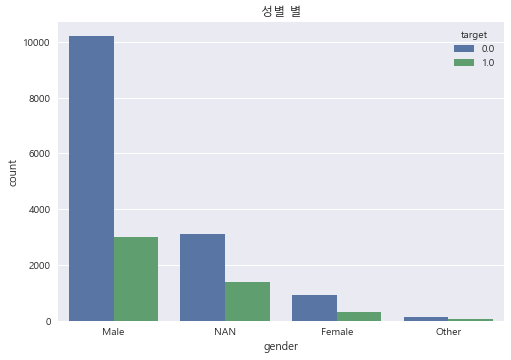

In [130]:
X['gender'].fillna('NAN', inplace=True)
sns.countplot(x='gender', hue='target', data=X)
plt.title('성별 별')
plt.show()
X.loc[X['gender']=='NAN', 'gender'] = np.nan

In [92]:
gender_nan_cnt = X['gender'].isna().sum()//2
X['gender'].fillna('Female', limit=gender_nan_cnt, inplace=True)
X['gender'].fillna('Male', inplace=True)

#### company_size, type(회사 인원수, 회사 종류)

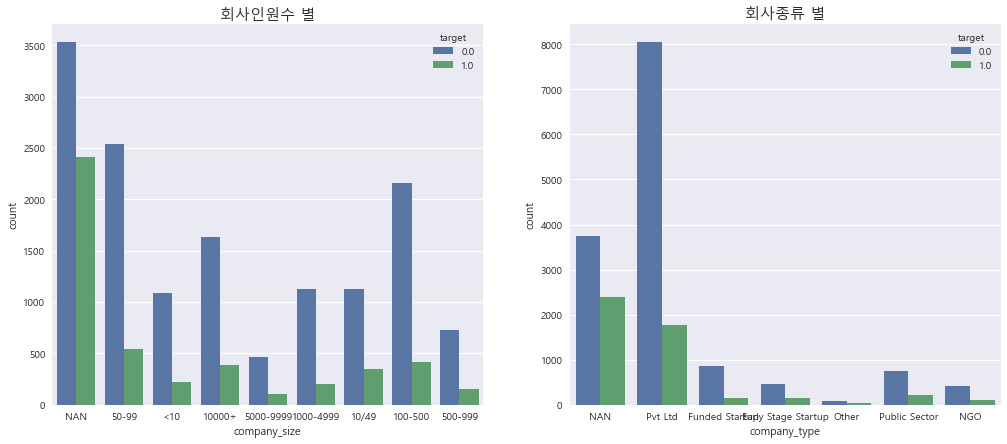

In [149]:
fig, axes = plt.subplots(2,1,figsize=(17,7))

X['company_size'].fillna('NAN', inplace=True)
X['company_type'].fillna('NAN', inplace=True)

plt.subplot(1,2,1)
sns.countplot(x='company_size', hue='target', data=X)
plt.title('회사인원수 별',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='company_type', hue='target', data=X)
plt.title('회사종류 별',fontsize=15)

X.loc[X['company_size']=='NAN', 'company_size'] = np.nan
X.loc[X['company_type']=='NAN', 'company_type'] = np.nan

plt.show()

In [93]:
X.loc[X['company_size'].isna(), 'company_size'] = 'unknown'
X.loc[X['company_size']=='<10', 'company_size'] = '~10'
X.loc[X['company_type'].isna(), 'company_type'] = 'unknown'

#### major_discipline(전공)

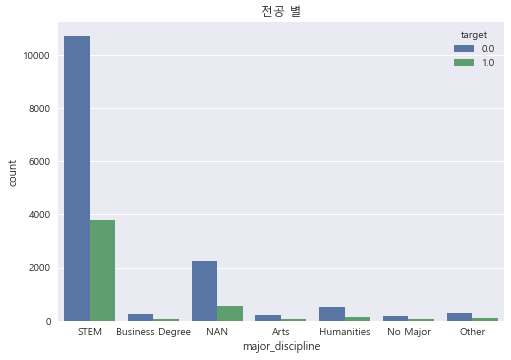

In [134]:
X['major_discipline'].fillna('NAN', inplace=True)
sns.countplot(x='major_discipline', hue='target', data=X)
plt.title('전공 별')
plt.show()
X.loc[X['major_discipline']=='NAN', 'major_discipline'] = np.nan

In [94]:
# 비율맞춰 처리
stem = X['major_discipline'].value_counts(dropna=False)['STEM']
nonstem = X.shape[0] - X['major_discipline'].isna().sum() - stem

major_limit = int(X['major_discipline'].isna().sum() / (stem+nonstem) * stem)
X['major_discipline'].fillna('major', limit=major_limit, inplace=True)
X['major_discipline'].fillna('no_major', inplace=True)

### 최종 결측치 처리: KNN

In [98]:
from sklearn.impute import KNNImputer

under_list = []
for col in X.columns:
    if X[col].isna().sum():
        under_list.append(col)
        
under_list

['enrolled_university',
 'education_level',
 'experience',
 'last_new_job',
 'target']

In [99]:
imputer = KNNImputer(n_neighbors = 1)
X[under_list] = imputer.fit_transform(X[under_list])

In [111]:
### 인코딩 전 현재 위아래로 concat되있어 
### 중복되있으므로 인덱스 순번대로 재지정

In [100]:
X.reset_index(drop=True, inplace=True)

## 1차 전처리:  city-lbe, elseobject-ohe

#### 라벨 인코딩

In [101]:
X['city'] = LabelEncoder().fit_transform(X['city'])

#### 원핫인코딩

In [136]:
to_ohe = list(X.columns[X[X.columns].dtypes == 'object'])
to_ohe

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'company_size',
 'company_type']

In [137]:
# 원핫 인코딩x 컬럼들
X_not_ohe = X.loc[:,~X.columns.isin(to_ohe)]
X_not_ohe.shape, X_not_ohe.columns

((21287, 6),
 Index(['enrollee_id', 'city_development_index', 'experience', 'last_new_job',
        'training_hours', 'target'],
       dtype='object'))

In [138]:
# 원핫 인코딩 컬럼들
X_ohe = X[to_ohe]
X_ohe

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,company_size,company_type
0,city_103,Male,Has relevent experience,0,2,STEM,NaN,NaN
1,city_40,Male,No relevent experience,0,2,STEM,50-99,Pvt Ltd
2,city_21,NaN,No relevent experience,2,2,STEM,NaN,NaN
3,city_115,NaN,No relevent experience,NaN,2,Business Degree,NaN,Pvt Ltd
4,city_162,Male,Has relevent experience,0,3,STEM,50-99,Funded Startup
...,...,...,...,...,...,...,...,...
2124,city_103,Male,No relevent experience,0,2,Humanities,NaN,Public Sector
2125,city_136,Male,Has relevent experience,0,3,STEM,NaN,NaN
2126,city_100,Male,No relevent experience,0,0,NaN,NaN,Pvt Ltd
2127,city_102,Male,Has relevent experience,2,1,NaN,100-500,Public Sector


In [105]:
# 원핫인코딩 실행
ohe = OneHotEncoder(sparse=False)
X_df = ohe.fit_transform(X_ohe)
X_ohe = pd.DataFrame(X_df, columns=ohe.get_feature_names())
X_ohe.shape, X_ohe.columns

# 합치기
X_new = pd.concat([X_ohe, X_not_ohe], axis=1)
X_new

X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   x0_Female                   21287 non-null  float64
 1   x0_Male                     21287 non-null  float64
 2   x0_Other                    21287 non-null  float64
 3   x1_Has relevent experience  21287 non-null  float64
 4   x1_No relevent experience   21287 non-null  float64
 5   x2_Arts                     21287 non-null  float64
 6   x2_Business Degree          21287 non-null  float64
 7   x2_Humanities               21287 non-null  float64
 8   x2_No Major                 21287 non-null  float64
 9   x2_Other                    21287 non-null  float64
 10  x2_STEM                     21287 non-null  float64
 11  x2_major                    21287 non-null  float64
 12  x2_no_major                 21287 non-null  float64
 13  x3_10/49                    212

### StandardScaled

In [106]:
from sklearn.preprocessing import StandardScaler

y_tmp = X_new['target']
X_scaled = StandardScaler().fit_transform(X_new)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_new.columns)
X_scaled_df.drop(columns='target',inplace=True)
X_scaled_df = pd.concat([X_scaled_df, y_tmp], axis=1)

#### enrollee_id 제거, 다시 train,test 분리 후 target 분리

In [107]:
X_scaled_df.loc[X_scaled_df.index,'target']

0        1.0
1        0.0
2        0.0
3        1.0
4        0.0
        ... 
21282    0.0
21283    0.0
21284    0.0
21285    0.0
21286    0.0
Name: target, Length: 21287, dtype: float64

In [108]:
X_train = X_scaled_df.loc[X_scaled_df.loc[X_scaled_df.index, 'target'] != -1]
X_test = X_scaled_df.loc[X_scaled_df.loc[X_scaled_df.index, 'target'] == -1]
X_test.drop(columns='target',inplace=True)

c:\users\inje.jeong\anaconda3\envs\ml\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### 테이블 저장

In [110]:
X_train.to_csv('../data/prepcd_train.csv', index=False)
X_test.to_csv('../data/prepcd_test.csv', index=False)